# Text - 분류 (Classification) 통합 템플릿
## Google Colab 실행용

- NUM_CLASSES = 2 → 이진분류 / NUM_CLASSES >= 3 → 다중분류
- 코드 변경 없이 자동 대응

**두 가지 접근법:**
- 방법 A: TF-IDF + ML (빠름, 5~10분)
- 방법 B: BERT Fine-tuning (높은 성능, 20~40분)

**실행 전**: 런타임 > 런타임 유형 변경 > GPU(T4) 선택 (방법 B 사용 시)

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 1. 데이터 로드

In [45]:
# [시험 구조]
# df_train = pd.read_csv('train.csv')  → train + val 분리 (레이블 있음)
# df_test  = pd.read_csv('test.csv')   → 최종 예측용 (레이블 없음)

# ==============================================
# [데이터셋 선택] 아래 중 하나만 주석 해제
# ==============================================
from sklearn.model_selection import train_test_split

# --- (A) 영어: 20 Newsgroups (4클래스 다중분류) ---
# from sklearn.datasets import fetch_20newsgroups
# categories = ['comp.graphics', 'sci.med', 'rec.sport.baseball', 'talk.politics.misc']
# newsgroups = fetch_20newsgroups(
#     subset='all', categories=categories,
#     remove=('headers', 'footers', 'quotes'), random_state=RANDOM_SEED
# )
# df_all = pd.DataFrame({'text': newsgroups.data, 'label': newsgroups.target})
# target_names = newsgroups.target_names
# df_train, df_test = train_test_split(
#     df_all, test_size=0.2, random_state=RANDOM_SEED, stratify=df_all['label']
# )
# df_train = df_train.reset_index(drop=True)
# df_test = df_test.reset_index(drop=True)
# TEXT_COL = 'text'
# TARGET = 'label'

# --- (B) 한국어: NSMC 네이버 영화 감성분석 (2클래스 이진분류) ---
# NSMC_TRAIN = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
# NSMC_TEST = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
# df_train = pd.read_csv(NSMC_TRAIN, sep='\t').dropna()
# df_test = pd.read_csv(NSMC_TEST, sep='\t').dropna()
# target_names = ['부정', '긍정']
# TEXT_COL = 'document'
# TARGET = 'label'

# --- (C) 한국어: KLUE-YNAT 뉴스 토픽분류 (7클래스 다중분류) ---
!pip install -q datasets
from datasets import load_dataset
klue = load_dataset('klue', 'ynat')
ynat_names = ['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치']
df_train = pd.DataFrame({'text': klue['train']['title'], 'label': klue['train']['label']})
df_test = pd.DataFrame({'text': klue['validation']['title'], 'label': klue['validation']['label']})
target_names = ynat_names
TEXT_COL = 'text'
TARGET = 'label'
NUM_CLASSES = df_train[TARGET].nunique()

print(f"Train 크기: {df_train.shape}")
print(f"Test  크기: {df_test.shape}")
print(f"클래스 수: {NUM_CLASSES} ({'이진분류' if NUM_CLASSES == 2 else '다중분류'})")
print(f"클래스 분포 (train):\n{df_train[TARGET].value_counts().sort_index()}")
print(f"클래스 이름: {target_names}")
df_train.head()

README.md: 0.00B [00:00, ?B/s]

ynat/train-00000-of-00001.parquet:   0%|          | 0.00/4.17M [00:00<?, ?B/s]

ynat/validation-00000-of-00001.parquet:   0%|          | 0.00/847k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45678 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/9107 [00:00<?, ? examples/s]

Train 크기: (45678, 2)
Test  크기: (9107, 2)
클래스 수: 7 (다중분류)
클래스 분포 (train):
label
0    5235
1    6118
2    5133
3    5751
4    8320
5    7742
6    7379
Name: count, dtype: int64
클래스 이름: ['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치']


,text,label
0,유튜브 내달 2일까지 크리에이터 지원 공간 운영,3
1,어버이날 맑다가 흐려져…남부지방 옅은 황사,3
2,내년부터 국가RD 평가 때 논문건수는 반영 않는다,2
3,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,2
4,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,3


## 2. EDA (탐색적 데이터 분석)

In [46]:
print("=" * 50)
print("[결측치 - Train]")
print(df_train.isnull().sum())

print(f"\n[텍스트 길이 통계 - Train]")
df_train['text_len'] = df_train[TEXT_COL].astype(str).apply(len)
print(df_train['text_len'].describe())

print(f"\n[빈 텍스트 수 - Train]: {(df_train[TEXT_COL].astype(str).str.strip() == '').sum()}")

[결측치 - Train]
text     0
label    0
dtype: int64

[텍스트 길이 통계 - Train]
count    45678.000000
mean        27.366544
std          4.864236
min          4.000000
25%         25.000000
50%         28.000000
75%         31.000000
max         44.000000
Name: text_len, dtype: float64

[빈 텍스트 수 - Train]: 0


## 3. 텍스트 전처리

**주요 전처리 항목:**
- HTML 태그 제거 → 웹 크롤링 데이터에 포함
- URL 제거 → 분류에 불필요
- 특수문자 제거 → 노이즈 제거 (한글/영문/숫자만 유지)
- 다중 공백 정리 → 토크나이저 입력 정규화
- 소문자 변환 (영어) → 'Apple'과 'apple'을 같은 단어로 처리

**선택적 전처리:**
- 불용어(stopwords) 제거 → `from nltk.corpus import stopwords`
- 형태소 분석 (한국어) → `from konlpy.tag import Okt`
- 어간 추출 (영어) → `from nltk.stem import PorterStemmer`

In [47]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).strip()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^\w\s가-힣a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    return text

df_train[TEXT_COL] = df_train[TEXT_COL].apply(clean_text)
df_train = df_train[df_train[TEXT_COL].str.len() > 0].reset_index(drop=True)
df_test[TEXT_COL] = df_test[TEXT_COL].apply(clean_text)
df_test = df_test[df_test[TEXT_COL].str.len() > 0].reset_index(drop=True)
print(f"전처리 후 Train: {df_train.shape}, Test: {df_test.shape}")

전처리 후 Train: (45678, 3), Test: (9107, 2)


---
# 방법 A: TF-IDF + ML (빠르고 안정적)

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Train → Train/Val 분할
df_tr, df_val = train_test_split(
    df_train, test_size=0.2, random_state=RANDOM_SEED, stratify=df_train[TARGET]
)
df_tr = df_tr.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
print(f"Train: {len(df_tr)}, Val: {len(df_val)}, Test: {len(df_test)}")

# TF-IDF 벡터화
# max_features: 최대 단어 수 (보통 5000~30000)
# ngram_range: (1,2)=단어+바이그램
# sublinear_tf: TF에 로그 스케일 적용
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)
# fit은 train에만, transform은 val/test에도 적용
X_train = tfidf.fit_transform(df_tr[TEXT_COL])
X_val = tfidf.transform(df_val[TEXT_COL])
y_train = df_tr[TARGET]
y_val = df_val[TARGET]
print(f"TF-IDF 행렬: Train={X_train.shape}, Val={X_val.shape}")

Train: 36542, Val: 9136, Test: 9107
TF-IDF 행렬: Train=(36542, 10000), Val=(9136, 10000)


### 모델 학습 및 비교

In [ ]:
ml_models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    'LinearSVC': LinearSVC(max_iter=2000, random_state=RANDOM_SEED),
    'MultinomialNB': MultinomialNB(alpha=0.1),
    #'RandomForest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED),
}

print("[TF-IDF + ML 모델 비교]")
results = {}
best_ml_acc = 0
best_ml_name = ''
best_ml_model = None

for name, model in ml_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    cv = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    results[name] = {'Accuracy': acc, 'F1_macro': f1, 'CV_Acc': cv}
    print(f"  [{name}] Accuracy={acc:.4f} | F1(macro)={f1:.4f} | CV={cv:.4f}")
    if acc > best_ml_acc:
        best_ml_acc = acc
        best_ml_name = name
        best_ml_model = model

results_df = pd.DataFrame(results).T.sort_values('Accuracy', ascending=False)
print(f"\n[모델 비교 결과]")
print(results_df)
print(f"\n1위 모델: {best_ml_name}")

[TF-IDF + ML 모델 비교]
  [LogisticRegression] Accuracy=0.7790 | F1(macro)=0.7637 | CV=0.7865
  [LinearSVC] Accuracy=0.7774 | F1(macro)=0.7611 | CV=0.7800
  [MultinomialNB] Accuracy=0.7699 | F1(macro)=0.7534 | CV=0.7775
  [RandomForest] Accuracy=0.7377 | F1(macro)=0.7210 | CV=0.7445

[모델 비교 결과]
                    Accuracy  F1_macro    CV_Acc
LogisticRegression  0.779006  0.763738  0.786492
LinearSVC           0.777364  0.761120  0.780007
MultinomialNB       0.769921  0.753430  0.777516
RandomForest        0.737741  0.721048  0.744458

1위 모델: LogisticRegression


### 최종 평가 + 성능 등급

In [50]:
y_pred_val = best_ml_model.predict(X_val)
acc_final = accuracy_score(y_val, y_pred_val)
f1_final = f1_score(y_val, y_pred_val, average='macro')

print(f"[최종 모델 성능 - Validation]")
print(f"Accuracy:   {acc_final:.4f}")
print(f"F1 (macro): {f1_final:.4f}")
print(f"\n[분류 보고서]")
print(classification_report(y_val, y_pred_val, target_names=target_names))

acc_grades = [(0.95, '매우 우수'), (0.90, '우수'), (0.85, '양호'), (0.80, '보통')]
acc_grade = '미흡'
for threshold, grade in acc_grades:
    if acc_final >= threshold:
        acc_grade = grade
        break

f1_grades = [(0.90, '매우 우수'), (0.80, '우수'), (0.70, '양호'), (0.60, '보통')]
f1_grade = '미흡'
for threshold, grade in f1_grades:
    if f1_final >= threshold:
        f1_grade = grade
        break

print(f"\n[성능 평가]")
print(f"Accuracy = {acc_final:.4f} -> {acc_grade}")
print(f"F1 Score = {f1_final:.4f} -> {f1_grade}")

[최종 모델 성능 - Validation]
Accuracy:   0.7790
F1 (macro): 0.7637

[분류 보고서]
              precision    recall  f1-score   support

        IT과학       0.73      0.77      0.75      1047
          경제       0.79      0.73      0.76      1224
          사회       0.54      0.49      0.51      1027
        생활문화       0.80      0.78      0.79      1150
          세계       0.76      0.83      0.79      1664
         스포츠       0.92      0.92      0.92      1548
          정치       0.81      0.81      0.81      1476

    accuracy                           0.78      9136
   macro avg       0.77      0.76      0.76      9136
weighted avg       0.78      0.78      0.78      9136


[성능 평가]
Accuracy = 0.7790 -> 미흡
F1 Score = 0.7637 -> 양호


### 성능 평가 기준

| 등급 | Accuracy | F1 (macro) |
|------|----------|------------|
| 매우 우수 | >= 0.95 | >= 0.90 |
| 우수 | 0.90~0.95 | 0.80~0.90 |
| 양호 | 0.85~0.90 | 0.70~0.80 |
| 보통 | 0.80~0.85 | 0.60~0.70 |
| 미흡 | < 0.80 | < 0.60 |

**텍스트 분류 특이사항:**
- TF-IDF + LogisticRegression/LinearSVC가 텍스트에서는 매우 강력
- BERT는 복잡한 문맥 이해가 필요한 경우에 유리

### 결과 CSV 파일 생성 (방법 A)

In [ ]:
#results_df.to_csv('text_model_comparison.csv')
#print("[저장] text_model_comparison.csv")
print(results_df)

In [51]:


# Validation 결과 CSV
label_map = {i: name for i, name in enumerate(target_names)}
val_result_df = df_val[[TEXT_COL, TARGET]].copy()
val_result_df['predicted'] = y_pred_val
val_result_df['correct'] = (y_val.values == y_pred_val).astype(int)
if target_names:
    val_result_df['actual_name'] = val_result_df[TARGET].map(label_map)
    val_result_df['predicted_name'] = val_result_df['predicted'].map(label_map)

#val_result_df.to_csv('text_classification_val_result.csv', index=False)
#print(f"\n[저장] text_classification_val_result.csv ({len(val_result_df)}건)")
print(val_result_df.head(10))

# Test 예측 → 제출 파일
X_test_tfidf = tfidf.transform(df_test[TEXT_COL])
y_pred_test = best_ml_model.predict(X_test_tfidf)
submit_df = df_test.copy()
submit_df['predicted'] = y_pred_test
if target_names:
    submit_df['predicted_name'] = submit_df['predicted'].map(label_map)
if TARGET in df_test.columns:
    test_acc = accuracy_score(df_test[TARGET], y_pred_test)
    test_f1 = f1_score(df_test[TARGET], y_pred_test, average='macro')
    submit_df['correct'] = (df_test[TARGET].values == y_pred_test).astype(int)
    print(f"\n[Test 성능] Accuracy={test_acc:.4f} | F1(macro)={test_f1:.4f}")

submit_df.to_csv('submission.csv', index=False)
print(f"[저장] submission.csv ({len(submit_df)}건)")
print(submit_df.head(10))

summary_df = pd.DataFrame([{
    'method': 'TF-IDF + ML',
    'model': best_ml_name,
    'val_accuracy': acc_final,
    'val_f1_macro': f1_final,
    'accuracy_grade': acc_grade,
    'f1_grade': f1_grade,
}])
#summary_df.to_csv('text_classification_summary.csv', index=False)
#print(f"\n[저장] text_classification_summary.csv")
print(summary_df)

[저장] text_model_comparison.csv

[저장] text_classification_val_result.csv (9136건)
                                       text  label  predicted  correct  \
0              국감서 청탁금지법 설왕설래 대통령도 위반 주장 논란      6          6        1   
1            박지원 달리는 호랑이 등에 탄 북미 정상 대화만이 살길      6          6        1   
2  주말 n 여행 강원권 아름다운 이야기가 흐른다 정선 동강 문화예술제 개막      3          3        1   
3            장원준 2년 연속 방어율 2위 올해는 1위 욕심 나네요      5          5        1   
4            미국 터키 시리아 안전지대 논의 재개했지만 입장차 여전      4          4        1   
5             특례 신설 적용 확대 기업활력법 공포안 국무회의 심의      6          2        0   
6               박영수 특검 靑 대법원장 사찰 의혹 파문 수사할까      6          2        0   
7                          참석자 소개에 박수치는 황교안      6          6        1   
8             文의장여야 3당 회동 무산 오늘 본회의 개의 어려워져      6          6        1   
9              朴대통령 안보리α 제재 한미일 공조로 北압박 극대화      6          6        1   

  actual_name predicted_name  
0          정치             정치  
1          정치             정치  
2        생활문

### 모델 저장 (방법 A)

In [52]:
import joblib
joblib.dump(best_ml_model, 'text_tfidf_model.pkl')
joblib.dump(tfidf, 'text_tfidf_vectorizer.pkl')
print("TF-IDF 모델 저장 완료: text_tfidf_model.pkl, text_tfidf_vectorizer.pkl")

TF-IDF 모델 저장 완료: text_tfidf_model.pkl, text_tfidf_vectorizer.pkl


---
# 방법 B: BERT Fine-tuning (높은 성능)

시간이 충분하고 GPU가 있을 때 사용. 방법 A로 성능이 충분하면 생략 가능.

**BERT 하이퍼파라미터:**
- `BERT_MODEL_NAME`: 한국어=`klue/bert-base` | 영어=`bert-base-uncased`
- `MAX_LENGTH`: 토큰 최대 길이 (128이 일반적, 긴 텍스트는 256~512)
- `BATCH_SIZE`: GPU 메모리에 맞게 조절 (16GB VRAM → 32)
- `EPOCHS`: 보통 3~5 (EarlyStopping이 조기 종료)
- `LEARNING_RATE`: 2e-5가 BERT 표준, 1e-5~5e-5 범위

In [53]:
!pip install -q transformers accelerate

import torch
from transformers import BertTokenizerFast, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(RANDOM_SEED)

# 영어 데이터 → 'bert-base-uncased' | 한국어 데이터 → 'klue/bert-base'
# BERT_MODEL_NAME = 'bert-base-uncased'
BERT_MODEL_NAME = 'klue/bert-base'
MAX_LENGTH = 128
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 2e-5

print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: Tesla T4


In [54]:
# 방법 A와 동일 분할 사용
X_train_text = df_tr[TEXT_COL].tolist()
X_val_text = df_val[TEXT_COL].tolist()
X_test_text = df_test[TEXT_COL].tolist()
y_train_b = df_tr[TARGET].tolist()
y_val_b = df_val[TARGET].tolist()
print(f"Train: {len(X_train_text)}, Val: {len(X_val_text)}, Test: {len(X_test_text)}")

tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

train_enc = tokenizer(
    X_train_text, truncation=True, padding=True,
    max_length=MAX_LENGTH, return_tensors='pt'
)
val_enc = tokenizer(
    X_val_text, truncation=True, padding=True,
    max_length=MAX_LENGTH, return_tensors='pt'
)
print(f"토크나이징 완료: Train={train_enc['input_ids'].shape}, Val={val_enc['input_ids'].shape}")

train_dataset = TensorDataset(
    train_enc['input_ids'], train_enc['attention_mask'],
    torch.tensor(y_train_b, dtype=torch.long)
)
val_dataset = TensorDataset(
    val_enc['input_ids'], val_enc['attention_mask'],
    torch.tensor(y_val_b, dtype=torch.long)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train: 36542, Val: 9136, Test: 9107


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

토크나이징 완료: Train=torch.Size([36542, 27]), Val=torch.Size([9136, 28])


### BERT 학습

In [55]:
bert_model = BertForSequenceClassification.from_pretrained(
    BERT_MODEL_NAME, num_labels=NUM_CLASSES
).to(device)

optimizer = torch.optim.AdamW(bert_model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
best_val_loss = float('inf')
patience_counter = 0
PATIENCE = 2

start_time = time.time()
for epoch in range(EPOCHS):
    # --- Train ---
    bert_model.train()
    total_loss, correct, total = 0, 0, 0
    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(labels)
        correct += (outputs.logits.argmax(1) == labels).sum().item()
        total += len(labels)
    train_loss = total_loss / total
    train_acc = correct / total

    # --- Eval ---
    bert_model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for input_ids, attention_mask, labels in val_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item() * len(labels)
            val_correct += (outputs.logits.argmax(1) == labels).sum().item()
            val_total += len(labels)
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - loss: {train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(bert_model.state_dict(), 'best_bert.pt')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"EarlyStopping at epoch {epoch+1}")
            break

bert_model.load_state_dict(torch.load('best_bert.pt'))
print(f"학습 완료: {(time.time()-start_time)/60:.1f}분")

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

Epoch 1/5 - loss: 0.4360 - acc: 0.8587 - val_loss: 0.3368 - val_acc: 0.8819
Epoch 2/5 - loss: 0.2781 - acc: 0.9043 - val_loss: 0.3524 - val_acc: 0.8785
Epoch 3/5 - loss: 0.2047 - acc: 0.9294 - val_loss: 0.3676 - val_acc: 0.8778
EarlyStopping at epoch 3
학습 완료: 10.9분


### BERT 학습 곡선

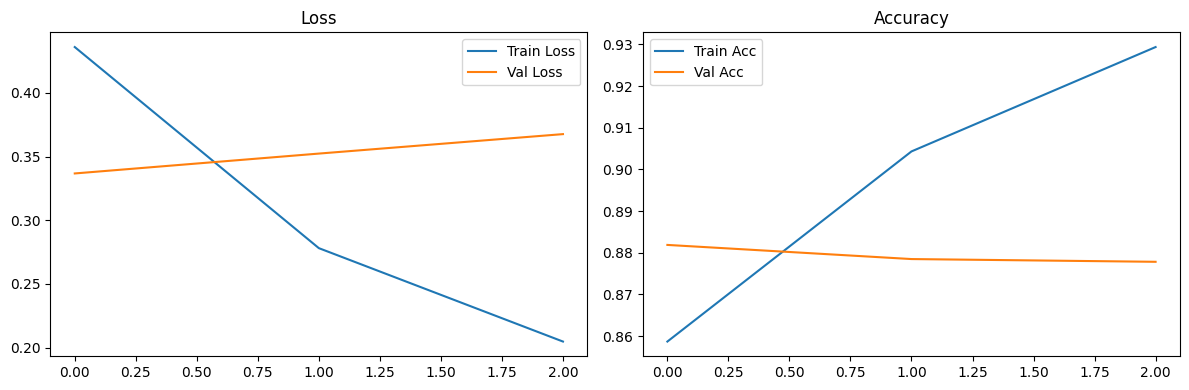

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history['loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss')
ax1.legend(); ax1.set_title('Loss')

ax2.plot(history['accuracy'], label='Train Acc')
ax2.plot(history['val_accuracy'], label='Val Acc')
ax2.legend(); ax2.set_title('Accuracy')
plt.tight_layout()
plt.show()

### BERT 평가

In [57]:
bert_model.eval()
all_preds = []
with torch.no_grad():
    for input_ids, attention_mask, labels in val_loader:
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        all_preds.extend(outputs.logits.argmax(1).cpu().numpy())

pred_labels = np.array(all_preds)
acc_bert = accuracy_score(y_val_b, pred_labels)
f1_bert = f1_score(y_val_b, pred_labels, average='macro')
print(f"[BERT - Validation] Accuracy={acc_bert:.4f} | F1(macro)={f1_bert:.4f}")
print(classification_report(y_val_b, pred_labels, target_names=target_names))

[BERT - Validation] Accuracy=0.8819 | F1(macro)=0.8670
              precision    recall  f1-score   support

        IT과학       0.79      0.91      0.85      1047
          경제       0.87      0.80      0.83      1224
          사회       0.75      0.61      0.67      1027
        생활문화       0.89      0.91      0.90      1150
          세계       0.92      0.95      0.93      1664
         스포츠       0.95      0.99      0.97      1548
          정치       0.92      0.91      0.91      1476

    accuracy                           0.88      9136
   macro avg       0.87      0.87      0.87      9136
weighted avg       0.88      0.88      0.88      9136



### 결과 CSV 파일 생성 (방법 B)

In [58]:
# Validation 결과 CSV
bert_val_df = pd.DataFrame({
    'text': X_val_text,
    'actual': y_val_b,
    'predicted': pred_labels,
    'correct': [1 if a == p else 0 for a, p in zip(y_val_b, pred_labels)],
})
if target_names:
    bert_val_df['actual_name'] = bert_val_df['actual'].map(label_map)
    bert_val_df['predicted_name'] = bert_val_df['predicted'].map(label_map)

#bert_val_df.to_csv('text_bert_val_result.csv', index=False)
#print(f"[저장] text_bert_val_result.csv ({len(bert_val_df)}건)")
print(bert_val_df.head(10))

# Test 예측 → 제출 파일
test_enc_bert = tokenizer(
    X_test_text, truncation=True, padding=True,
    max_length=MAX_LENGTH, return_tensors='pt'
)
bert_model.eval()
with torch.no_grad():
    test_outputs = bert_model(
        input_ids=test_enc_bert['input_ids'].to(device),
        attention_mask=test_enc_bert['attention_mask'].to(device)
    )
test_pred_labels = test_outputs.logits.argmax(1).cpu().numpy()

bert_submit_df = df_test.copy()
bert_submit_df['predicted'] = test_pred_labels
if target_names:
    bert_submit_df['predicted_name'] = bert_submit_df['predicted'].map(label_map)
if TARGET in df_test.columns:
    test_acc_b = accuracy_score(df_test[TARGET], test_pred_labels)
    test_f1_b = f1_score(df_test[TARGET], test_pred_labels, average='macro')
    bert_submit_df['correct'] = (df_test[TARGET].values == test_pred_labels).astype(int)
    print(f"\n[BERT Test 성능] Accuracy={test_acc_b:.4f} | F1(macro)={test_f1_b:.4f}")

#bert_submit_df.to_csv('submission_bert.csv', index=False)
#print(f"[저장] submission_bert.csv ({len(bert_submit_df)}건)")
print(bert_submit_df)

bert_summary_df = pd.DataFrame([{
    'method': 'BERT Fine-tuning',
    'model': BERT_MODEL_NAME,
    'val_accuracy': acc_bert,
    'val_f1_macro': f1_bert,
}])
#bert_summary_df.to_csv('text_bert_summary.csv', index=False)
#print(f"\n[저장] text_bert_summary.csv")
print(bert_summary_df)

[저장] text_bert_val_result.csv (9136건)
                                       text  actual  predicted  correct  \
0              국감서 청탁금지법 설왕설래 대통령도 위반 주장 논란       6          6        1   
1            박지원 달리는 호랑이 등에 탄 북미 정상 대화만이 살길       6          6        1   
2  주말 n 여행 강원권 아름다운 이야기가 흐른다 정선 동강 문화예술제 개막       3          3        1   
3            장원준 2년 연속 방어율 2위 올해는 1위 욕심 나네요       5          5        1   
4            미국 터키 시리아 안전지대 논의 재개했지만 입장차 여전       4          4        1   
5             특례 신설 적용 확대 기업활력법 공포안 국무회의 심의       6          2        0   
6               박영수 특검 靑 대법원장 사찰 의혹 파문 수사할까       6          2        0   
7                          참석자 소개에 박수치는 황교안       6          6        1   
8             文의장여야 3당 회동 무산 오늘 본회의 개의 어려워져       6          6        1   
9              朴대통령 안보리α 제재 한미일 공조로 北압박 극대화       6          6        1   

  actual_name predicted_name  
0          정치             정치  
1          정치             정치  
2        생활문화           생활문화  
3         스포

### 모델 저장 (방법 B)

In [ ]:
#bert_model.save_pretrained('text_bert_model')
#tokenizer.save_pretrained('text_bert_model')
#print("BERT 모델 저장 완료: text_bert_model/")

# 로드 방법:
# model = BertForSequenceClassification.from_pretrained('text_bert_model')
# tokenizer = BertTokenizerFast.from_pretrained('text_bert_model')

torch.save(bert_model, 'model_state_dict.pt')
#loaded_model = torch.load('model_state_dict.pt')

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

BERT 모델 저장 완료: text_bert_model/


In [61]:
torch.save(bert_model, 'model_state_dict.pt')

In [60]:
test_texts = df_test[TEXT_COL].apply(clean_text)
X_submit = tfidf.transform(test_texts)
predictions = best_ml_model.predict(X_submit)
df_test['predicted'] = predictions
df_test.to_csv('submission.csv', index=False)

# 방법 B (BERT - PyTorch) 사용 시:
test_texts = df_test[TEXT_COL].apply(clean_text).tolist()
test_enc = tokenizer(test_texts, truncation=True, padding=True,
                      max_length=MAX_LENGTH, return_tensors='pt')
bert_model.eval()
with torch.no_grad():
    outputs = bert_model(
        input_ids=test_enc['input_ids'].to(device),
        attention_mask=test_enc['attention_mask'].to(device)
    )
pred_labels = outputs.logits.argmax(1).cpu().numpy()
df_test['predicted'] = pred_labels
df_test.to_csv('submission.csv', index=False)

---
## 제출 파일 생성 (실제 시험)

```python
# 방법 A (TF-IDF) 사용 시:
test_texts = df_test[TEXT_COL].apply(clean_text)
X_submit = tfidf.transform(test_texts)
predictions = best_ml_model.predict(X_submit)
df_test['predicted'] = predictions
df_test.to_csv('submission.csv', index=False)

# 방법 B (BERT - PyTorch) 사용 시:
test_texts = df_test[TEXT_COL].apply(clean_text).tolist()
test_enc = tokenizer(test_texts, truncation=True, padding=True,
                      max_length=MAX_LENGTH, return_tensors='pt')
bert_model.eval()
with torch.no_grad():
    outputs = bert_model(
        input_ids=test_enc['input_ids'].to(device),
        attention_mask=test_enc['attention_mask'].to(device)
    )
pred_labels = outputs.logits.argmax(1).cpu().numpy()
df_test['predicted'] = pred_labels
df_test.to_csv('submission.csv', index=False)
```